In [235]:
# install libraries
import influxdb_client
import pandas as pd
import secret
from sensor_data_functions import get_sensor_data
from weather_data_functions import get_weather_data
from irradiance_data_functions import irradiance_data, get_lat_long
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import math
import pytz
import ast

In [236]:
year = 2024
month = 1
day = 1
date_time = datetime(year=year, month=month, day=day)

generation_df, consumption_df = get_sensor_data(date_time)

generation_df.head()

Data not found in local storage, querying influxdb


,power
datetime,
2024-01-01 00:00:00+00:00,0.082043
2024-01-01 00:00:01+00:00,0.084521
2024-01-01 00:00:02+00:00,0.082354
2024-01-01 00:00:03+00:00,0.083634
2024-01-01 00:00:04+00:00,0.083362


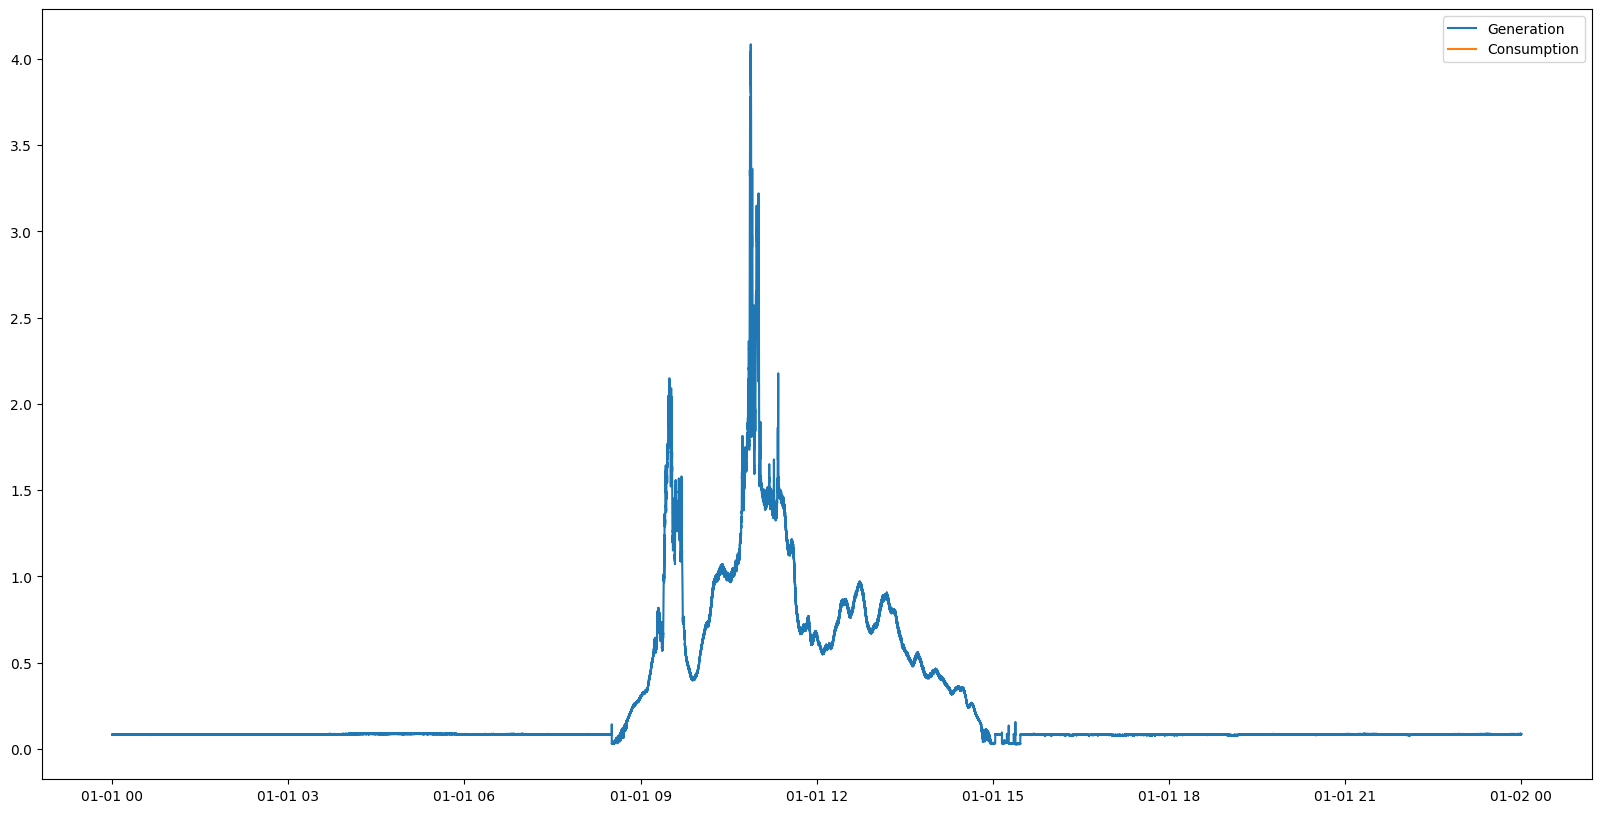

In [237]:
# plot both generation and consumption
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(generation_df.index, generation_df['power'], label='Generation')
ax.plot(consumption_df.index, consumption_df['power'], label='Consumption')
ax.legend()

In [238]:
postcode = 'WR7 4BU'

weather = get_weather_data(postcode, date_time)
weather.head()

Weather data loaded from API


,time_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,...,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,uv,condition
time,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,1704067200,6.9,44.3,0,21.3,34.2,263,W,996.0,29.42,...,0,45,0,0,9.0,5.0,32.3,52.0,1.0,Thundery outbreaks possible
2024-01-01 01:00:00,1704070800,6.7,44.0,0,19.7,31.7,270,W,998.0,29.46,...,0,45,0,0,10.0,6.0,30.0,48.3,1.0,Patchy rain possible
2024-01-01 02:00:00,1704074400,6.2,43.1,0,18.6,29.9,261,W,999.0,29.49,...,0,45,0,0,10.0,6.0,29.2,46.9,1.0,Cloudy
2024-01-01 03:00:00,1704078000,5.8,42.4,0,18.1,29.2,261,W,1000.0,29.52,...,0,45,0,0,10.0,6.0,29.8,48.0,1.0,Patchy rain possible
2024-01-01 04:00:00,1704081600,6.0,42.8,0,18.1,29.2,261,W,1000.0,29.54,...,0,45,0,0,10.0,6.0,28.6,46.0,1.0,Patchy rain possible


In [239]:
irradiance = irradiance_data(postcode, date_time)
# convert start_time to the index
irradiance = irradiance.set_index('start_time')
# convert index to datetime
irradiance.index = pd.to_datetime(irradiance.index)
# drop start and end time columns
irradiance = irradiance.drop(columns=['start', 'end'])
irradiance.head()

No local data available, calling API


,clear_sky_ghi,clear_sky_dni,clear_sky_dhi,cloudy_sky_ghi,cloudy_sky_dni,cloudy_sky_dhi
start_time,,,,,,
2024-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0


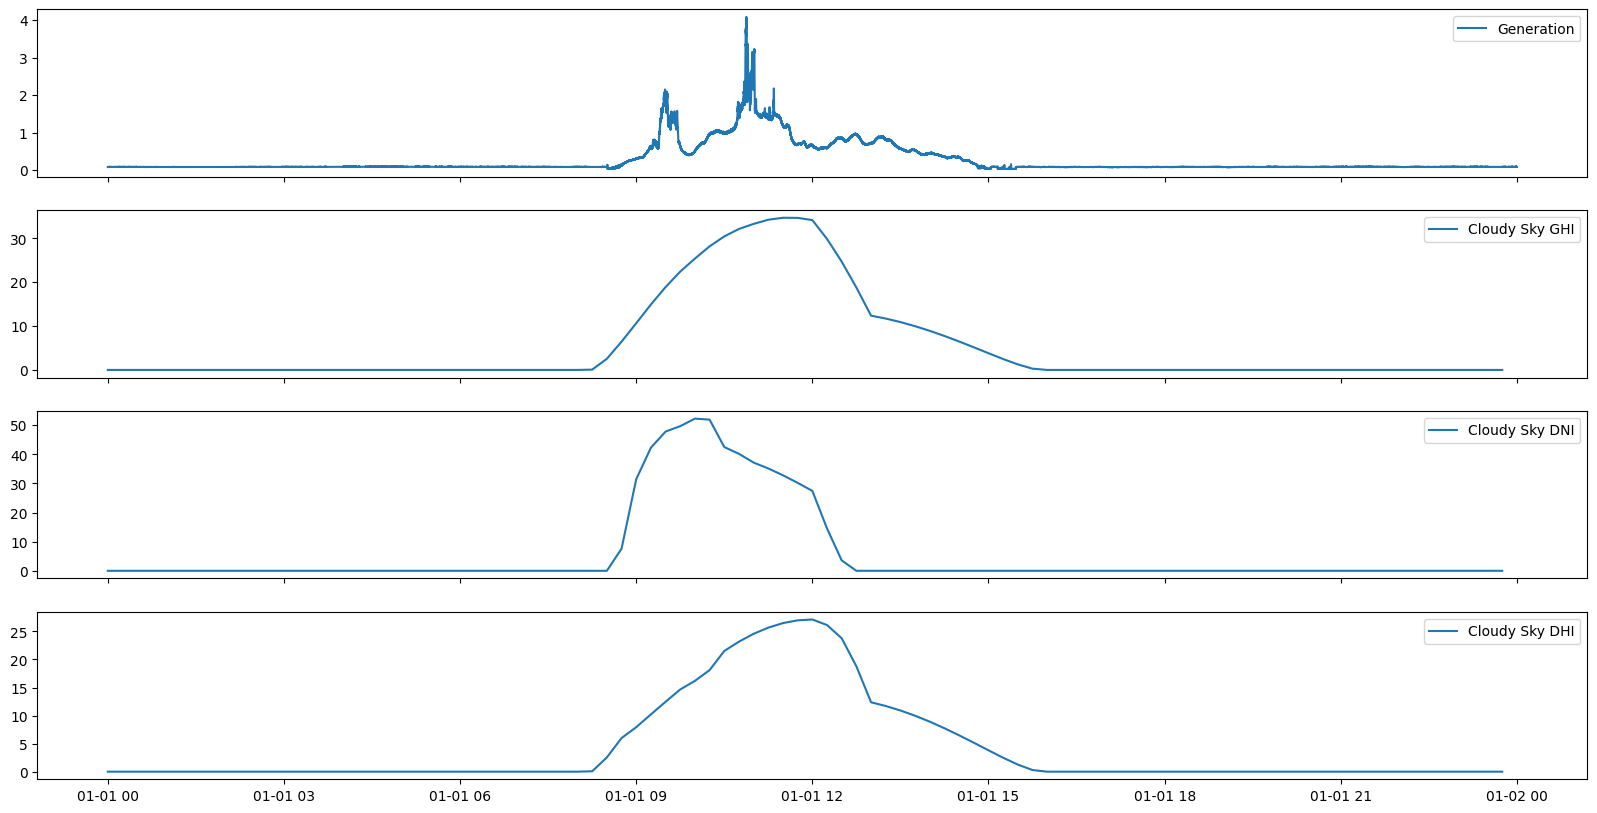

In [244]:
# plot the irradiance data and sensor data on the same graph
fig, ax = plt.subplots(figsize=(20, 10), nrows=4, sharex=True)

ax[1].plot(irradiance.index, irradiance['cloudy_sky_ghi'], label='Cloudy Sky GHI')
ax[2].plot(irradiance.index, irradiance['cloudy_sky_dni'], label='Cloudy Sky DNI')
ax[3].plot(irradiance.index, irradiance['cloudy_sky_dhi'], label='Cloudy Sky DHI')
# ax[1].plot(irradiance['start_time'], irradiance['clear_sky_ghi'], label='Clear Sky GHI')
# ax[1].plot(irradiance['start_time'], irradiance['clear_sky_dni'], label='Clear Sky DNI')
# ax[1].plot(irradiance['start_time'], irradiance['clear_sky_dhi'], label='Clear Sky DHI')
ax[0].plot(generation_df.index, generation_df['power'], label='Generation')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

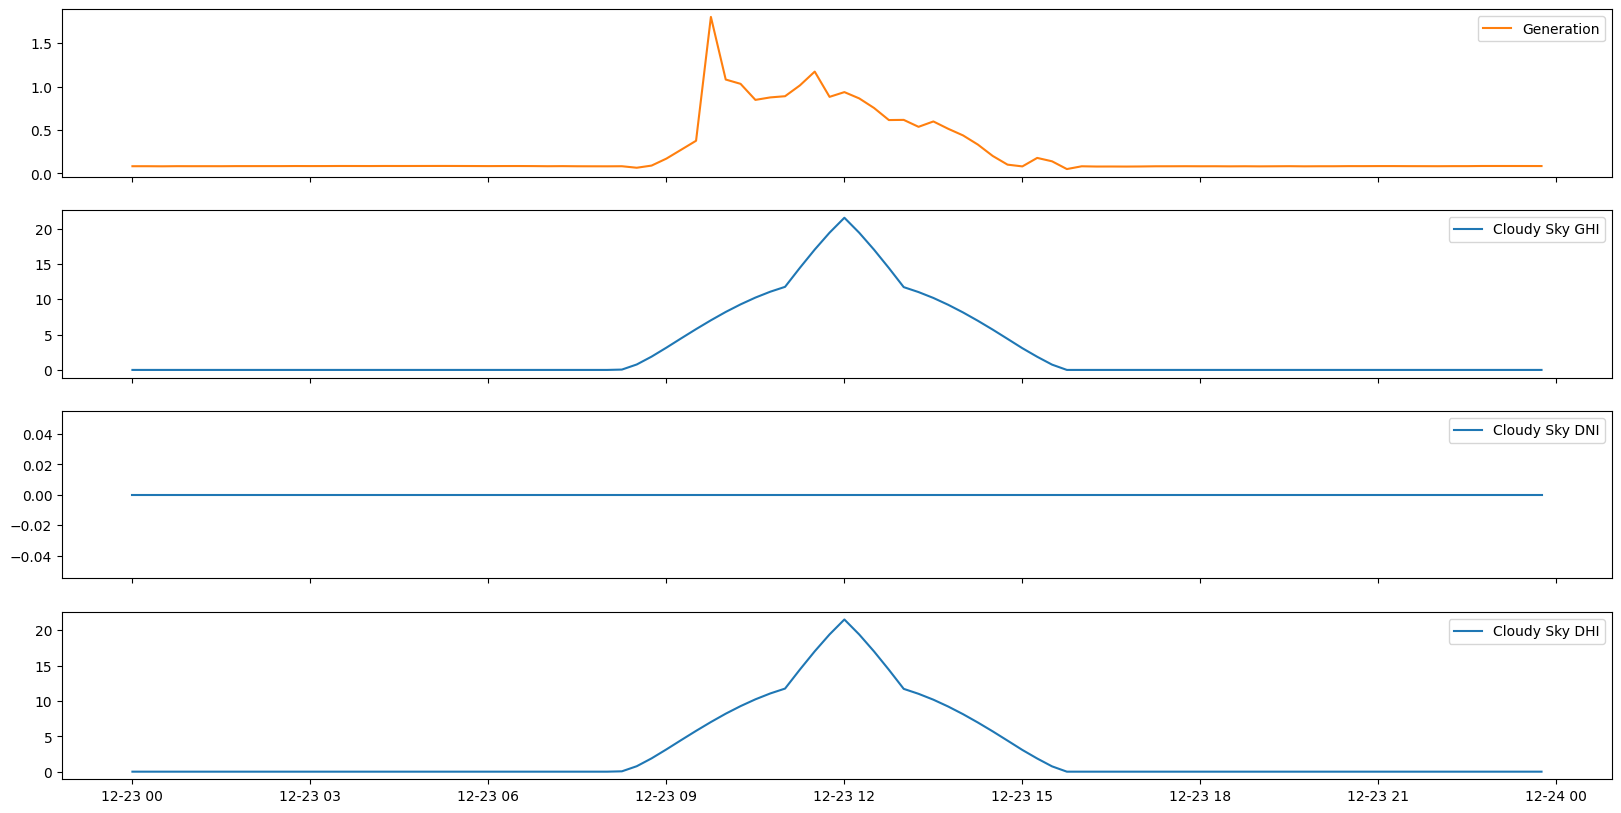

In [ ]:
'''
There seems like no point really in trying to predict the second by second variations in the irradiance data (generation_df). 
lets just use the average irradiance for the hour.
'''

# get the average irradiance for the hour
averaging_period = '15Min'
generation_df = generation_df.resample(averaging_period).mean()

# plot the irradiance data and sensor data on the same graph
fig, ax = plt.subplots(figsize=(20, 10), nrows=4, sharex=True)

ax[0].plot(generation_df.index, generation_df['power'], label='Generation', color='tab:orange')
ax[1].plot(irradiance['start_time'], irradiance['cloudy_sky_ghi'], label='Cloudy Sky GHI')
ax[2].plot(irradiance['start_time'], irradiance['cloudy_sky_dni'], label='Cloudy Sky DNI')
ax[3].plot(irradiance['start_time'], irradiance['cloudy_sky_dhi'], label='Cloudy Sky DHI')

for index in ax:
    index.legend()


    


In [ ]:
'''
lets visualise the data that may be relevant at 15 minute intervals (we may have to edit and duplicate some items to get the data in the right format)

Data to include:
- actual generation
- temperature
- wind speed
- cloud cover
- irradiance
- visibility
- UV index
- Condition
- rain
'''

averaging_period = '15Min'

'''actual generation'''
actual_generation = generation_df.resample(averaging_period).mean()

'''temperature'''
temperature = pd.DataFrame(weather['temp_c'].resample(averaging_period).interpolate())

'''wind speed'''
wind = pd.DataFrame(weather['wind_kph'].resample(averaging_period).interpolate())

'''cloud cover'''
cloud = pd.DataFrame(weather['cloud'].resample(averaging_period).interpolate())

'''irradiance'''
irradiance = irradiance.resample(averaging_period).interpolate()

'''visibility'''
visibility = pd.DataFrame(weather['vis_km'].resample(averaging_period).interpolate())

'''UV index'''
UV = pd.DataFrame(weather['uv'].resample(averaging_period).interpolate())

'''Condition'''
condition = pd.DataFrame(weather['condition'].resample(averaging_period).interpolate())
condition

/var/folders/hp/vg51f9ss37n33r4qdw2s_1880000gn/T/ipykernel_89761/772369529.py:40: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  condition = pd.DataFrame(weather['condition'].resample(averaging_period).interpolate())


,condition
time,
2023-12-23 00:00:00,Overcast
2023-12-23 00:15:00,NaN
2023-12-23 00:30:00,NaN
2023-12-23 00:45:00,NaN
2023-12-23 01:00:00,Partly cloudy
...,...
2023-12-23 22:00:00,Overcast
2023-12-23 22:15:00,NaN
2023-12-23 22:30:00,NaN


In [ ]:
weather.iloc[0]

time_epoch        1703289600
temp_c                   7.4
temp_f                  45.3
is_day                     0
wind_mph                14.5
wind_kph                23.4
wind_degree              258
wind_dir                 WSW
pressure_mb           1017.0
pressure_in            30.02
precip_mm                0.0
precip_in                0.0
humidity                  85
cloud                     90
feelslike_c              3.7
feelslike_f             38.7
windchill_c              3.7
windchill_f             38.7
heatindex_c              7.4
heatindex_f             45.3
dewpoint_c               5.0
dewpoint_f              40.9
will_it_rain               0
chance_of_rain             0
will_it_snow               0
chance_of_snow             0
vis_km                  10.0
vis_miles                6.0
gust_mph                23.8
gust_kph                38.3
uv                       1.0
condition           Overcast
Name: 2023-12-23 00:00:00, dtype: object